# Enhancing Speech Emotion Classification by utilizing a Convolutional Neural Network: A deep learning approach to Audio Classification

Emil Vinod¹
## Import Python Modules

In [1]:
import os                          # Operating system-related functionality
from glob import glob              # File pattern matching

In [2]:
import numpy as np                 # Numerical operations
import pandas as pd                # Data manipulation and analysis
import seaborn as sns              # Data visualization
import matplotlib.pylab as plt    # Plotting

In [3]:
from tqdm import tqdm             # Progress bars
from scipy.io import wavfile      # Reading WAV files

In [4]:
import IPython.display as ipd     # Audio playback
import librosa                     # Audio analysis
import librosa.display            # Audio visualization

In [5]:
from sklearn.utils.class_weight import compute_class_weight   # Class weight computation
from python_speech_features import mfcc, logfbank             # Audio feature extraction

In [6]:
from keras.models import Sequential                       # Keras Sequential model
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM   # Keras layers
from keras.layers import Dropout, Dense, TimeDistributed    #Keras Layers
from keras.utils import to_categorical                    # Keras utility functions

In [7]:
from itertools import cycle       # Iterator-based looping

## Methodology : Convolutional Neural Network-Based Speech Emotion Recognition

Utilizes the RAVDESS DataSet
Livingstone SR, Russo FA (2018) The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391. ²

**Preprocessing the Audio Files:**
  - Loading the audio files from the RAVDESS dataset.
  - Applying necessary preprocessing steps such as resampling and normalization to ensure consistency across the data.
  - Performing Fast Fourier Transform (FFT) to analyze the frequency content of the audio samples.
  - Applying downsampling to reduce the sampling rate of the audio data.
  - Generating spectrograms, filter banks and mel frequency cepstrum coefficient to visualize the frequency content of emotional speech over time.
  - Applying Short Time Fourier Transform (STFT) to capture variations in spectral content over short-time intervals.
  - Utilizing a Mel Filterbank to emphasize important frequency bands for emotional analysis.
  - Performing feature engineering to extract additional meaningful features.


**Feature Extraction:**

Extracting relevant features from the preprocessed audio data:
   
  - **MFCC (Mel-Frequency Cepstral Coefficients):** Represent the spectral characteristics of the audio signal.
  - **Fbank (Filter Bank):** A bank of filters that are spaced equally on the mel scale, which is a perceptual scale of pitches.

(Additional) Researched features with potential preprocessing gain:
   
  - **Shimmer:** Measure the variations in amplitude of the speech signal.
  - **Harmonic to Noise Ratio:** Assess the presence of harmonic components in relation to noise.
  - **Voiced and Unvoiced Segments:** Determine the proportion of voiced and unvoiced speech segments.
  - **Alpha ratio and Hammarberg Index:** Additional acoustic features related to speech quality.
  - **Spectral Flux:** Measure the rate of change of the spectral content over time.
  - **Fundamental Frequency:** Extract pitch-related information.
  - **Loudness and Intensity:** Capture the overall sound level and strength.
  - **Jitter:** Quantify the variations in vocal cord vibrations.
  - **Formants (F1, F2, F3):** Identify resonant frequencies in the speech signal.

**Model Integration:**
 - Designing the architecture of the CNN for speech emotion recognition.
 - Including convolutional layers, pooling layers, and fully connected layers in the CNN model.
 - Using the extracted features as input to the CNN for training and inference.
 - Training the CNN model using the labeled audio data from the RAVDESS dataset.

**Evaluation:**
 - Evaluating the performance of the CNN model in terms of emotion recognition accuracy.
 - Measuring the model's ability to classify emotions accurately based on the audio features.

**Further Improvements:**
 - Refining and enhance the feature set based on the results and analysis.
 - Exploring advanced CNN architectures or additional audio processing techniques to improve the performance of the model.
 - Fine-tuning the CNN model and optimize hyperparameters to achieve better results.


By incorporating these audio processing techniques and using a CNN model for speech emotion recognition, we can effectively extract meaningful features and train a model to accurately classify emotions in speech.

## Audio Pre-processing utilizing the RAVDESS dataset:

### Importing RAVDESS Audio Files

In [8]:
#Importing the RAVDESS DataSet
RAV = 'RAVDESS_AudioDataSet'

In [9]:
# Create empty lists to store the dataset information
emotion = []
gender = []
path = []
duration = []

# Iterate over each subfolder in the RAVDESS directory
for actor_folder in os.listdir(RAV):
    actor_path = os.path.join(RAV, actor_folder)
    if not os.path.isdir(actor_path):
        continue
    
    # Iterate over each WAV file in the actor's folder
    for wav_file in os.listdir(actor_path):
        if not wav_file.endswith('.wav'):
            continue
        
        # Extract information from the file name
        part = wav_file.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        
        # Determine the gender based on the file name
        if temp % 2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        
        # Store the complete path of the audio file
        file_path = os.path.join(actor_path, wav_file)
        path.append(file_path)
        
        # Calculate the duration of the audio file
        audio, sr = librosa.load(file_path)
        duration.append(round(len(audio) / sr, 2))

# Create a DataFrame with all the collected information
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1: 'neutral', 2: 'neutral', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender), RAV_df], axis=1)
RAV_df.columns = ['gender', 'emotion']
RAV_df['labels'] = RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df, pd.DataFrame(path, columns=['path'])], axis=1)
RAV_df = pd.concat([RAV_df, pd.DataFrame(duration, columns=['duration_seconds'])], axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)

### Visualizing the RAV_dataframe

In [10]:
# Display the frequency of the labels
RAV_df.labels.value_counts()

labels
male_neutral       144
female_neutral     144
male_happy          96
male_sad            96
male_angry          96
male_fear           96
male_disgust        96
male_surprise       96
female_happy        96
female_sad          96
female_angry        96
female_fear         96
female_disgust      96
female_surprise     96
Name: count, dtype: int64

In [11]:
# Displaying the DataFrame
RAV_df

,labels,source,path,duration_seconds
0,male_neutral,RAVDESS,RAVDESS_AudioDataSet\Actor_01\03-01-01-01-01-0...,3.30
1,male_neutral,RAVDESS,RAVDESS_AudioDataSet\Actor_01\03-01-01-01-01-0...,3.34
2,male_neutral,RAVDESS,RAVDESS_AudioDataSet\Actor_01\03-01-01-01-02-0...,3.27
3,male_neutral,RAVDESS,RAVDESS_AudioDataSet\Actor_01\03-01-01-01-02-0...,3.17
4,male_neutral,RAVDESS,RAVDESS_AudioDataSet\Actor_01\03-01-02-01-01-0...,3.54
...,...,...,...,...
1435,female_surprise,RAVDESS,RAVDESS_AudioDataSet\Actor_24\03-01-08-01-02-0...,3.40
1436,female_surprise,RAVDESS,RAVDESS_AudioDataSet\Actor_24\03-01-08-02-01-0...,3.94
1437,female_surprise,RAVDESS,RAVDESS_AudioDataSet\Actor_24\03-01-08-02-01-0...,3.97
1438,female_surprise,RAVDESS,RAVDESS_AudioDataSet\Actor_24\03-01-08-02-02-0...,3.67


### Identifying and Normalizing Data Variations to ensure consistency

In [12]:
# Analysing the distribution of durations across the labels to filter significant variations
classes = list(np.unique(RAV_df.labels))
class_dist = RAV_df.groupby(['labels'])['duration_seconds'].mean()

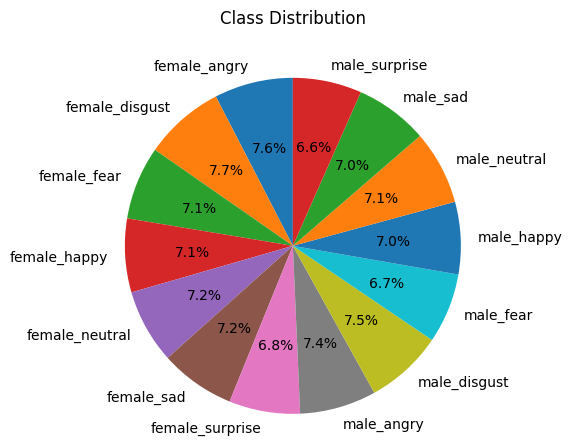

In [13]:
# Displaying the mean variation between the labels
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y = 1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',shadow=False, startangle =90)
ax.axis('equal')
plt.show()
RAV_df.reset_index(inplace=True)

### Feature Visualisation : Utilizing Plots to Understand Features

In [14]:
#Dictionaries to store the Plot Values
signals = {}
fft = {}
fbank = {}
mfccs = {}

In [15]:
#Function to Remove Blank Dead Spaces and Junk data from audio signal to increase relevance
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask. append(True)
        else:
            mask. append(False)
    return mask

In [16]:
#Function performing a Fast Fourier Transform
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)

In [29]:
#Functions to Generate Plots
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=True, figsize=(20, 5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x, y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x, y].get_xaxis().set_visible(False)
            axes[x, y].get_yaxis().set_visible(False)
            i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=True, figsize=(20, 5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x, y].set_title(list(signals.keys())[i])
            axes[x, y].plot(freq, Y)
            axes[x, y].get_xaxis().set_visible(False)
            axes[x, y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=True, figsize=(20, 5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x, y].set_title(list(fbank.keys())[i])
            axes[x, y].imshow(list(fbank.values())[i], interpolation='nearest', cmap='hot')
            axes[x, y].get_xaxis().set_visible(False)
            axes[x, y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x, y].set_title(list(mfccs.keys())[i])
            axes[x, y].imshow(list(mfccs.values())[i], interpolation='nearest', cmap='hot')
            axes[x, y].get_xaxis().set_visible(False)
            axes[x, y].get_yaxis().set_visible(False)
            i +=1

In [30]:
#Compiling and Resampling
for c in classes:
    wav_file = str(RAV_df[RAV_df.labels == c].iloc[0,3])
    signal, rate = librosa.load(wav_file, sr=44100)
    mask = envelope(signal, rate, 0.0005)
    signal = signal[mask]
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    
    bank = logfbank(signal[:rate], rate, nfilt = 26, nfft=1103).T
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    mfccs[c]=mel

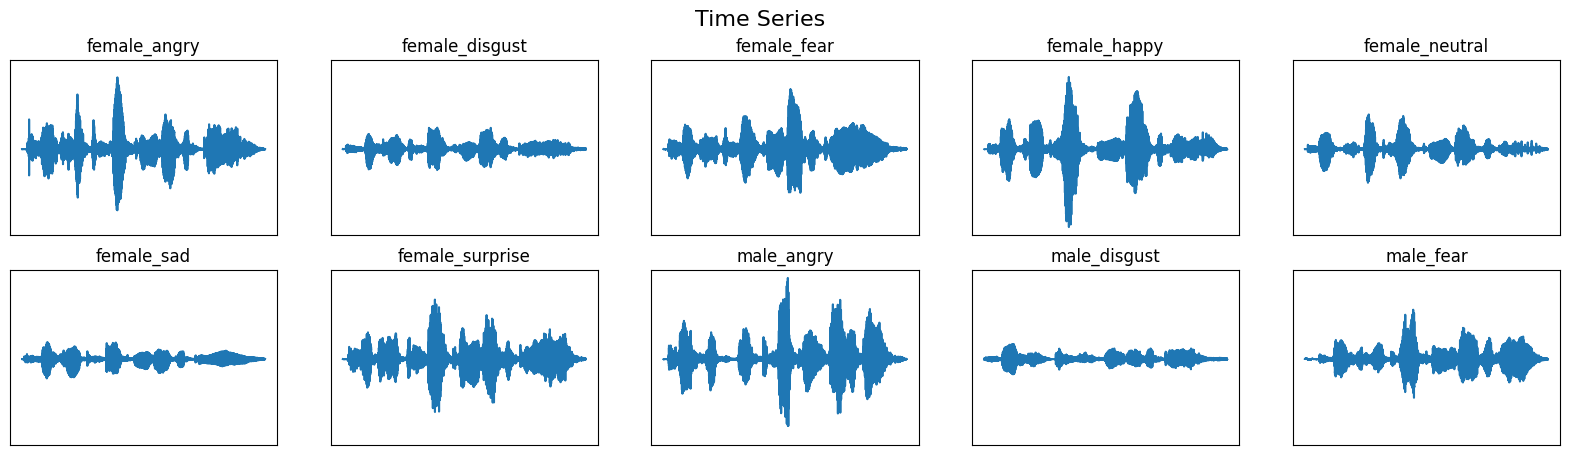

In [31]:
plot_signals(signals)
plt.show()

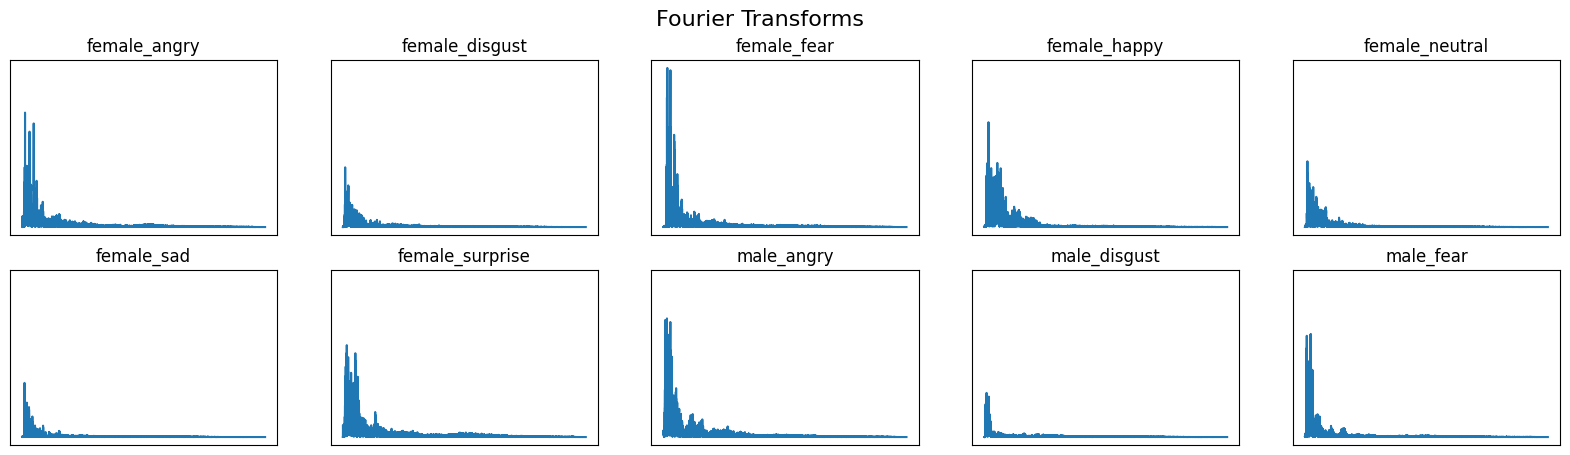

In [32]:
plot_fft(fft)
plt.show()

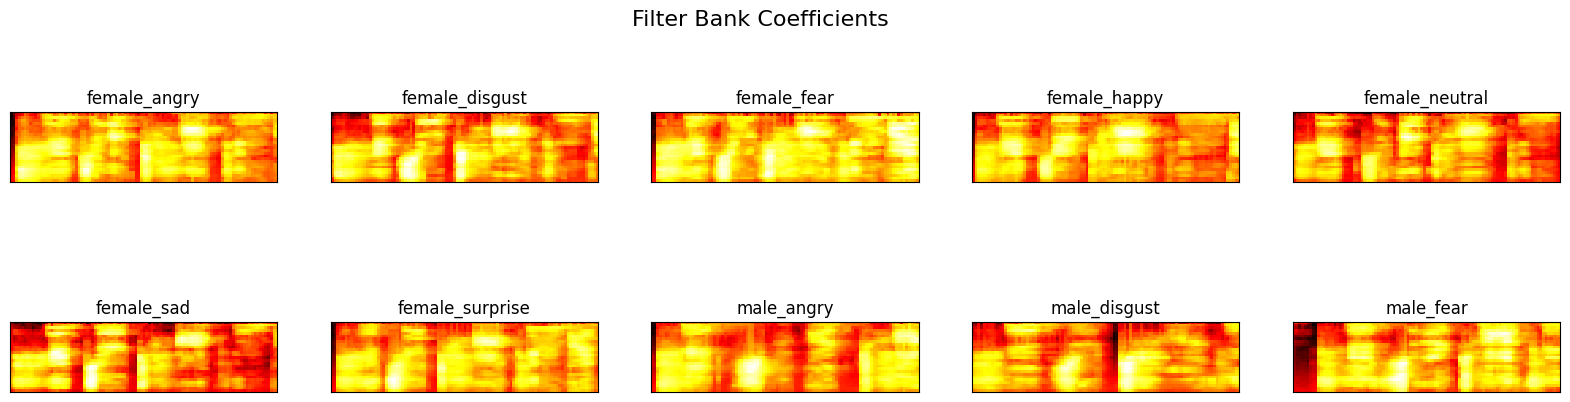

In [33]:
plot_fbank(fbank)
plt.show()

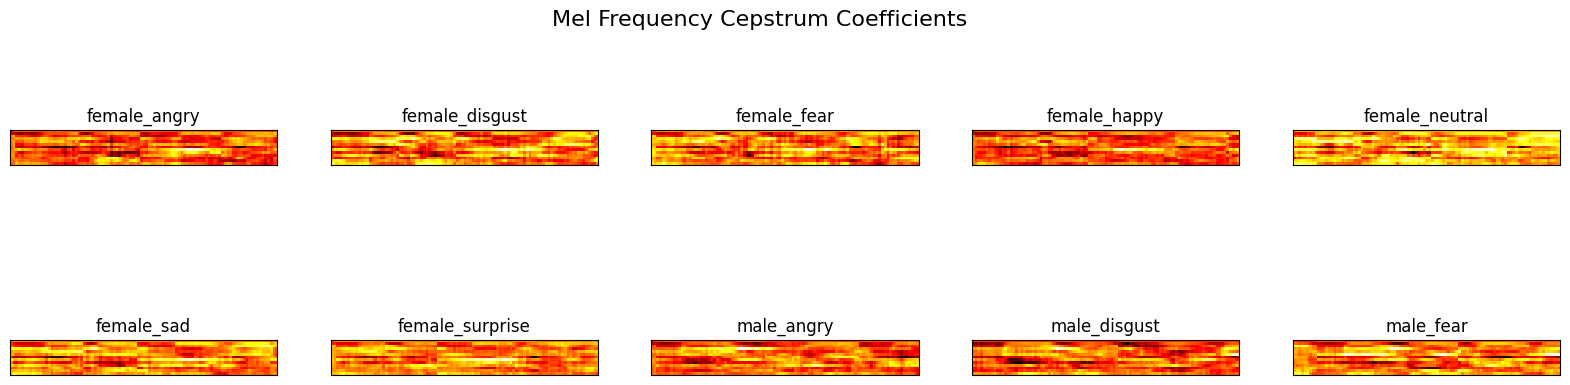

In [34]:
plot_mfccs(mfccs)
plt.show()

### Cleaning and Storing processed audio Data

In [36]:
# Downsampling data to remove unnecesarry high frequencies and removing dead space
if len(os.listdir('Clean'))== 1:
    for f in tqdm(RAV_df.path):
        signal, rate = librosa.load(f, sr=16000)
        mask = envelope(signal, rate, 0.005)
        wavfile.write(filename='Clean/'+f, rate=rate, data=signal[mask])

100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [00:20<00:00, 71.11it/s]
